In [273]:
import time
from math import cos, pi, exp
import numpy
from numba import njit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [274]:
y = 5
n_args_count = 1  # количество x-ов, подаваемых в тестовую функцию
iter_max = 500  # больше 500 не нужно
number_of_agents = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight = 50  # максимальный вес рыбы

##Реализация алгоритма

In [275]:
@njit()
def main_function():
    step_ind = list()
    step_vol = list()
    p_qbest_list = list()  # массив p_qbest в разные моменты поколений
    # step_ind.append(float(input("Введите макс размер шага индивидуального перемещения: ")))
    # step_vol.append(float(input("Введите макс размер шага коллективно-волевого перемещения: ")))
    step_ind.append(0.05)
    step_vol.append(0.05)
    w = list()
    w.append(numpy.zeros(number_of_agents) + max_weight / 2)

    t = 0  # текущий номер поколения
    P = list()  # Начальная популяция
    P.append(generate_agents())  # Случано сгенерированное текущее поколение
    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list.append(p_qbest)

    f_t = list()
    f_min = f(P[t][0])
    f_t.append(f_min)
    for i in range(1, number_of_agents):
        f_I = f(P[t][i])
        if f_I < f_min:
            f_min = f_I
            p_qbest = P[t][i]
        f_t.append(f_I)

    # значение функции для каждого агента
    F = [numpy.array(f_t)]
    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind.append(step_ind[0] * exp(-y * t / iter_max))
        step_vol.append(step_vol[0] * exp(-y * t / iter_max))

        P.append(numpy.copy(P[t - 1]))
        w.append(numpy.copy(w[t - 1]))
        F.append(numpy.zeros(number_of_agents))
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]):
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        delta_F = numpy.zeros(number_of_agents)
        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        for i in range(number_of_agents):
            delta_F[i] = F[t][i] - F[t - 1][i]
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = 0
            for i in range(number_of_agents):
                s += P_mul_F[i][j]
            I_t[j] = s
        I_t /= sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = 0
        for i in range(number_of_agents):
            sm2 += w[t][i]
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if sum(w[t]) > sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        for i in P[t]:
            if f(p_qbest) > f(i):
                p_qbest = i
        p_qbest_list.append(p_qbest)

    return p_qbest_list

In [276]:
def draw_graphic(f_val, functon_name):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [277]:
def draw_distribution_graphic(best_values, function_name):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    dispersion = numpy.sqrt(numpy.var(best_values))
    plt.plot(numpy.arange(10), numpy.zeros(10), c="fuchsia")
    plt.fill_between(numpy.arange(10), numpy.zeros(10) - dispersion, numpy.zeros(10) + dispersion, color="fuchsia", alpha=0.2)
    plt.show()

In [278]:
def start_test(function_name):
    best_qbest_tests = list()  # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function()
        best = best_lst[-1]
        end = time.time() - start
        best_qbest_tests.append(best)
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        f_val = [f(i) for i in best_lst]
        draw_graphic(f_val, function_name)
    draw_distribution_graphic(best_qbest_tests, function_name)


##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [279]:
@njit()
def f(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i ** 2 - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [280]:
@njit()
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-5.12, 5.12, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.00058107]
The function value of pqbest:		6.698497654866742e-05
Algorithm running time:			3.088193416595459 s


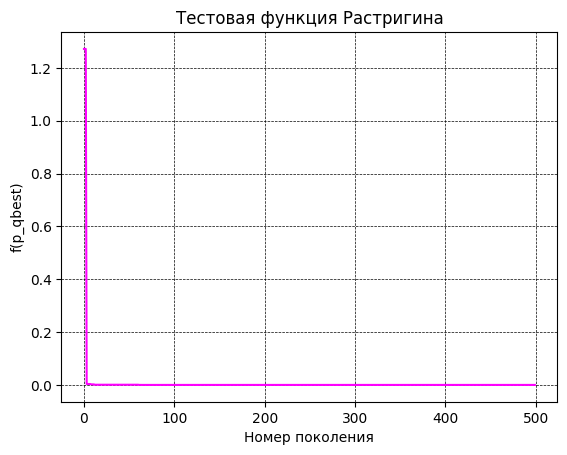

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[0.0001687]
The function value of pqbest:		5.645846004043165e-06
Algorithm running time:			0.020983457565307617 s


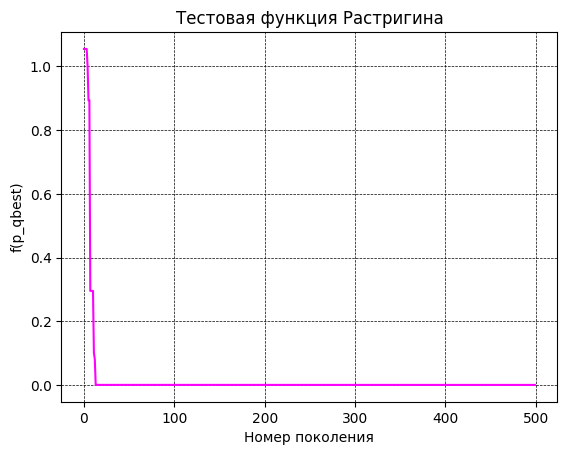

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[1.29276201e-05]
The function value of pqbest:		3.315595265007687e-08
Algorithm running time:			0.020005226135253906 s


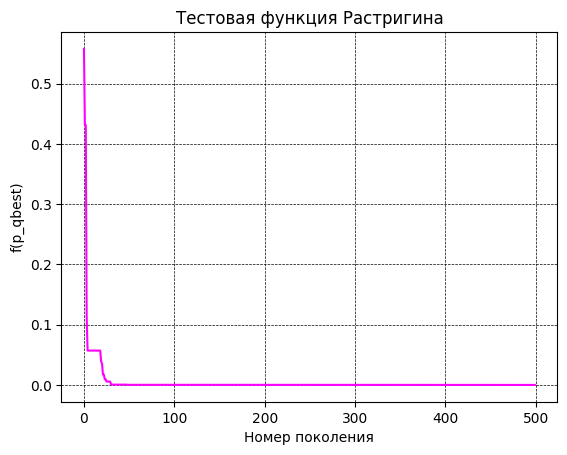

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[0.00222952]
The function value of pqbest:		0.0009861397617818568
Algorithm running time:			0.021004915237426758 s


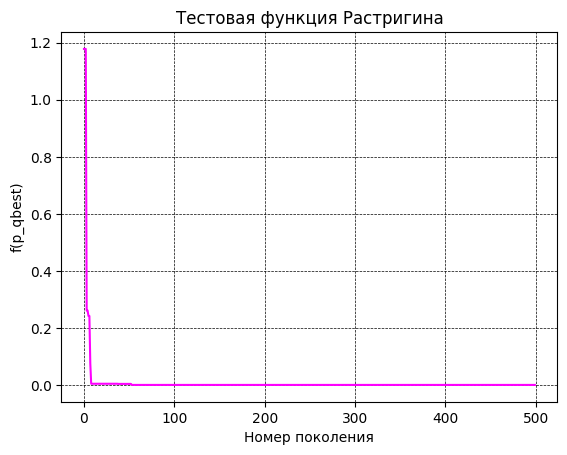

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[0.00014735]
The function value of pqbest:		4.307536556780178e-06
Algorithm running time:			0.019021034240722656 s


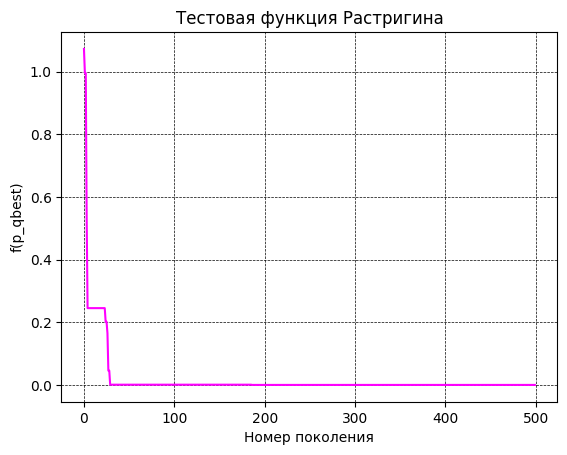

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[8.98619862e-05]
The function value of pqbest:		1.60205109445144e-06
Algorithm running time:			0.020987272262573242 s


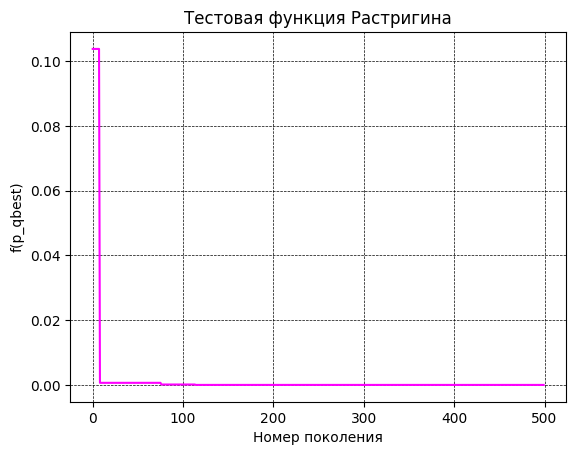

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-3.69002786e-05]
The function value of pqbest:		2.701367289859036e-07
Algorithm running time:			0.021004915237426758 s


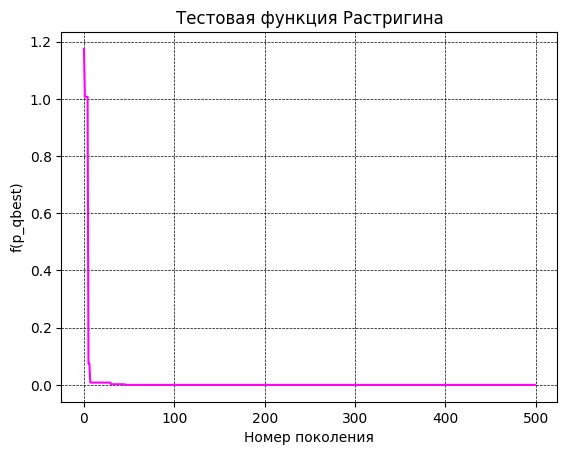

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[4.12817228e-05]
The function value of pqbest:		3.38095951235573e-07
Algorithm running time:			0.021003007888793945 s


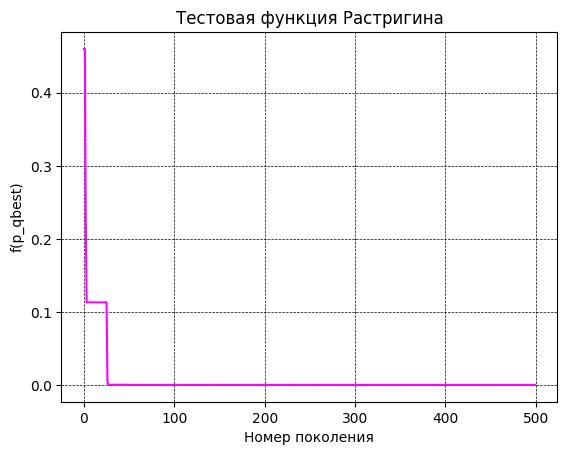

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[2.8012341e-05]
The function value of pqbest:		1.556765347743294e-07
Algorithm running time:			0.02001667022705078 s


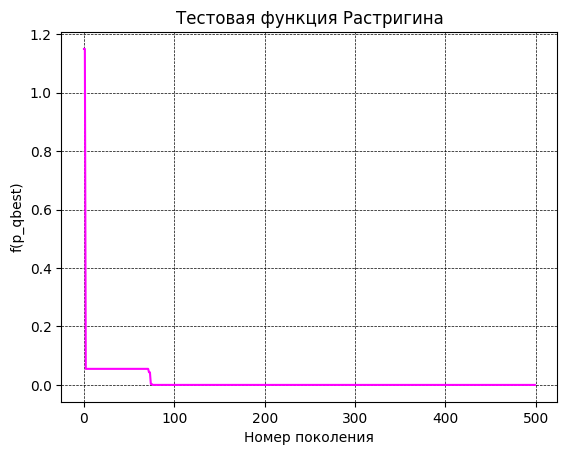

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.00024259]
The function value of pqbest:		1.1675515468212438e-05
Algorithm running time:			0.019997835159301758 s


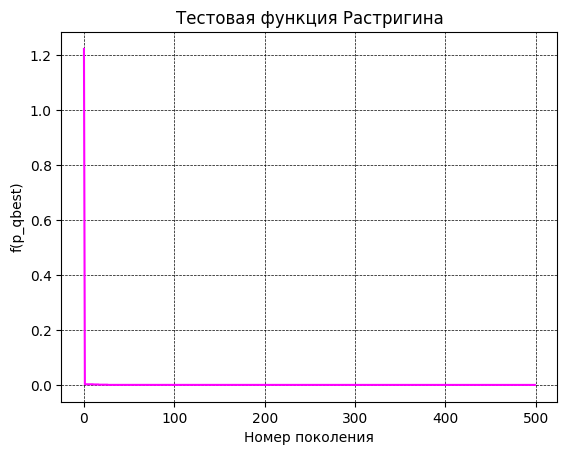

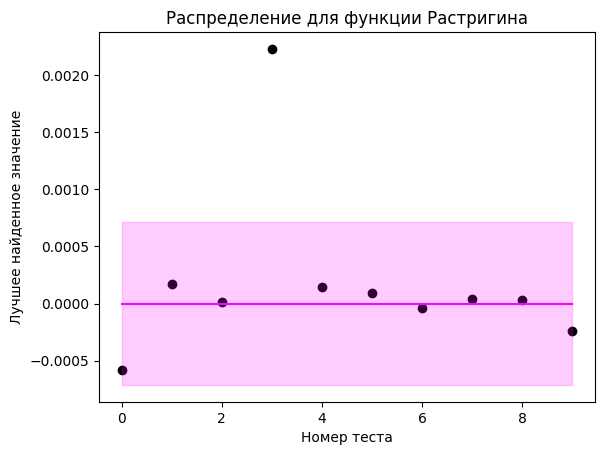

In [281]:
start_test("Растригина")